### Modeling the Xylose utilization pathway (XUP) based on Tellurium  

Models (XUP-XR and XUP-XI) are extracted from:  
Kinetic modelling reveals current limitations in the production of ethanol from xylose by recombinant Saccharomyces cerevisiae. Metab Eng. 2011 Sep;13(5):508-17.

In [1]:
import pandas as pd
import numpy as np
import os, glob, sys
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#from enzo import PathwaySet
import tellurium as te
import tellurium.temiriam as temiriam
te.setDefaultPlottingEngine('matplotlib')
import phrasedml

In [3]:
sys.path.append('../')
from enzo import PathwaySet

### Creating model string to run simulation based on Tellurium

#### The XUP-XI model is borrowed from Parachin et.al 2011.  
NOTE: for more details on parameters have a look at Tochampa_etal_2005.pdf.  

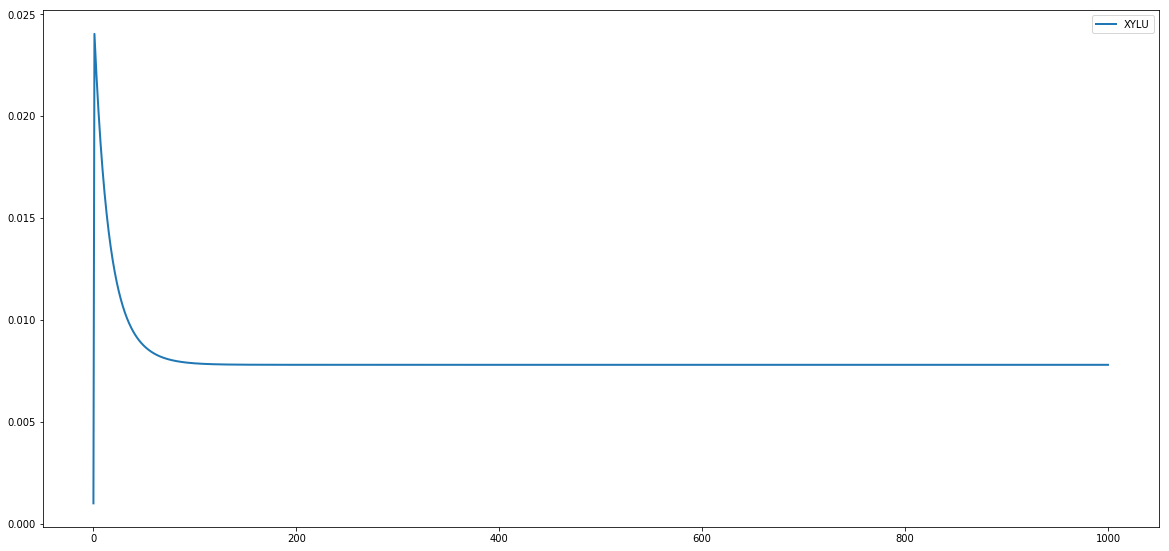

Steady state value is: 
0.0077975576874027


In [4]:
mode_XUP_XI_str = """
    
    // Biochemical reactions definition:
    
    Vtrspin := (Vmaxtrsp * (XYLe/KmTrsp)) / (1 + (XYLe/KmTrsp) + ((alpha * (XYLe/KmTrsp) +1) / (alpha * (XYL/KmTrsp) +1)) * (1 + (XYL/KmTrsp)));
    
    Vtrspout := (Vmaxtrsp * (XYL/KmTrsp)) / (1 + (XYL/KmTrsp) + ((alpha * (XYL/KmTrsp) +1) / (alpha * (XYLe/KmTrsp) +1)) * (1 + (XYLe/KmTrsp)));
    
    VXK := (VmaxXK * ((XYLU * ATP) / (KmXYLU1 * KmATP))) / (1 + (XYLU / KmXYLU1) + (ATP / KmATP) + ((XYLU * ATP) / (KmXYLU1 * KmATP)));

    VXI := ((VmaxXIf* (XYL/KmXYL)) - (VmaxXIr * (XYLU/KmXYLU))) / (1 + (XYL/KmXYL) + (XYLU/KmXYLU))
    
    
    // Reaction steps  
    J1: -> XYLe ; Vtrspout * Cx;
    J2: XYLe -> ; Vtrspin * Cx;
    J3: ->  XYL; Vtrspin * Px;
    J4: XYL ->  ; (Vtrspout * Px + VXI);
    J5: ->  XYLU; VXI;
    J6: XYLU ->  ; VXK;
    J7: Cx ->  ; Cx * rx;    

    // Parameters:
    Vmaxtrsp=22.2; 
    KmTrsp=146.0; 
    alpha=0.83;
    KmXYL=50; 
    KmXYLU=15; 
    VmaxXK=15240; 
    KmATP=1.55; 
    KmXYLU1=0.31;
    Px = 120; #Cell density in units of g DCW l-1 cell volume
    rx=0.05;
    VmaxXIf=1986.5;
    VmaxXIr=2581.8;
 
    // Species Initializations:
    XYLe=54.18; 
    XYL=0; 
    XYLU=0.001;  
    Cx=1.306;
    
    ATP=0.534;  
       
    // Other declarations:
    var Vtrspin, Vtrspout, VXK, VXI;
    const ATP
"""

r = te.loada(mode_XUP_XI_str)
result = r.simulate(0, 1000, 1000, selections=['time','XYLU'])

p = r.plot(figsize=(20, 9.5),show=True)
plt.show()
print("Steady state value is: ")
baseline_xylu_ss = r.getSteadyStateValues()[np.where(np.array(r.getFloatingSpeciesIds())=='XYLU')[0][0]]
print(baseline_xylu_ss)

### Multi-parameter perturbation experiment

In [7]:
#define parameter to be perturbed
param2mutat = ["Vmaxtrsp","KmTrsp","KmXYLU1","VmaxXIf","KmXYL","VmaxXIr","KmXYLU"]

r = te.loada(mode_XUP_XI_str)

paramids2values = dict(zip(r.getGlobalParameterIds(),r.getGlobalParameterValues()))
init_param_value = np.array([paramids2values[k] for k in param2mutat])

In [8]:
num_perturbs = 1000
rand_pert_dist = np.random.gamma(1.5, 3, (num_perturbs,init_param_value.shape[0]))
rand_pert_list = init_param_value*rand_pert_dist

In [9]:
timeseries_cont = []
ss_cont = []
for p in rand_pert_list:
    r.reset()
    r.setValues(keys=param2mutat,values=p)
    result = r.simulate(0, 1000, 100, selections=['time','XYLU'])
    timeseries_cont.append(result['XYLU'])
    ss_cont.append(r.getSteadyStateValues()[np.where(np.array(r.getFloatingSpeciesIds())=='XYLU')[0][0]])

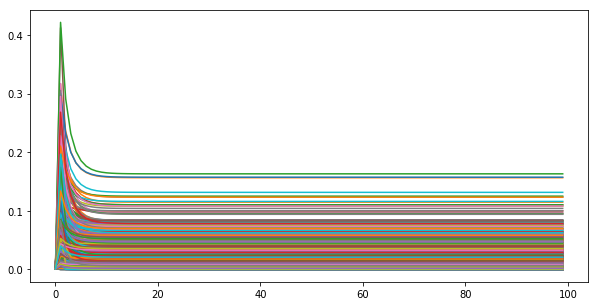

In [10]:
plt.figure(figsize=(10,5))
for ts in timeseries_cont:
    plt.plot(ts)
plt.show()    

### Distribution of steady state values for XYLU

In [11]:
rel_change2baseline = np.array(ss_cont)/baseline_xylu_ss

Median relative change to baseline is:  1.9556926493543734
Max relative change to baseline is:  20.940447119300355




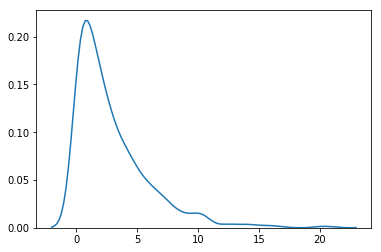

In [12]:
print("Median relative change to baseline is: ", np.median(rel_change2baseline))
print("Max relative change to baseline is: ", np.max(rel_change2baseline))
print ("\n")
sns.distplot(rel_change2baseline,hist=False)
plt.show()